In [57]:
%load_ext autoreload
%autoreload 2

In [139]:
import akantu as aka
import numpy as np
import matplotlib.pyplot as plt

from contact_mechanics_internodes import ContactMechanicsInternodes
from helper import plot_mesh, write_solution

In [168]:
mesh_file = 'mesh/contact2d_circle.msh'
material_file = 'material/material.dat'
spatial_dimension = 2
aka.parseInput(material_file)

mesh = aka.Mesh(spatial_dimension)
mesh.read(mesh_file)

model = aka.SolidMechanicsModel(mesh)
model.initFull(_analysis_method=aka._implicit_dynamic)

model.applyBC(aka.FixedValue(0., aka._x), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._y), 'primary_fixed')
model.applyBC(aka.FixedValue(0., aka._x), 'secondary_fixed')
model.applyBC(aka.FixedValue(-0.05, aka._y), 'secondary_fixed')

# Get positions of all nodes, surface connectivity and candidate nodes
nodal_positions = mesh.getNodes().copy()
surface_connectivity = mesh.getConnectivity(aka._segment_2).copy()
nodes_candidate_primary = mesh.getElementGroup('primary_candidates').getNodeGroup().getNodes().ravel().copy()
nodes_candidate_secondary = mesh.getElementGroup('secondary_candidates').getNodeGroup().getNodes().ravel().copy()
external_force = model.getExternalForce().copy()
nodal_displacements = model.getDisplacement().copy()
nodes_blocked = model.getBlockedDOFs().copy()

model.assembleMass()
M = aka.AkantuSparseMatrix(model.getDOFManager().getMatrix('M')).toarray()

model.assembleStiffnessMatrix()
K = aka.AkantuSparseMatrix(model.getDOFManager().getMatrix('K')).toarray()

E = model.getMaterial(0).getReal("E")

# Set initial conditions
internodes_model = ContactMechanicsInternodes(spatial_dimension, nodal_positions, nodal_displacements, surface_connectivity, nodes_candidate_primary, nodes_candidate_secondary, nodes_blocked, external_force, M, K, E)

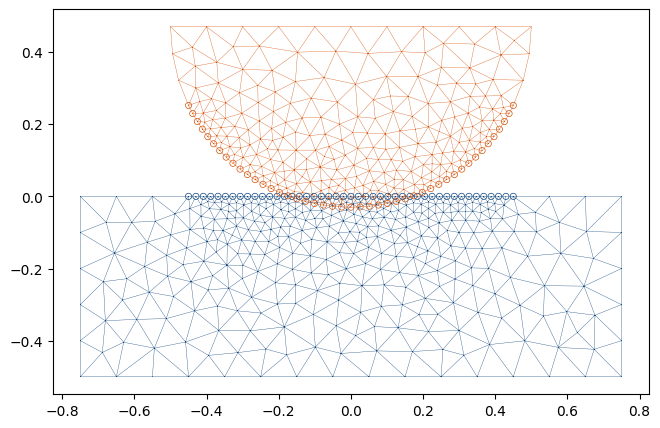

----> Starting iteration 1 <----


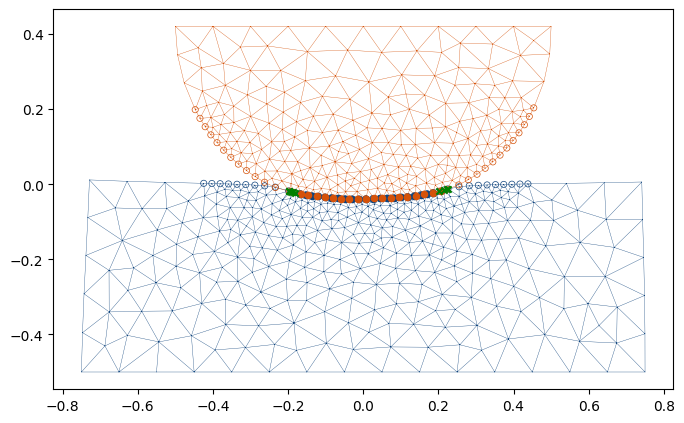

----> Starting iteration 2 <----


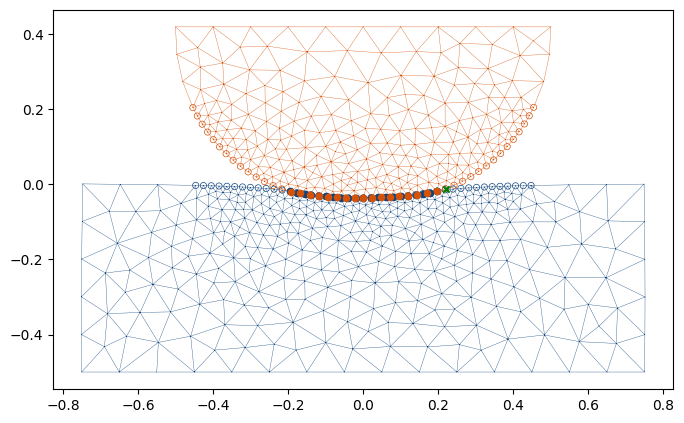

----> Starting iteration 3 <----


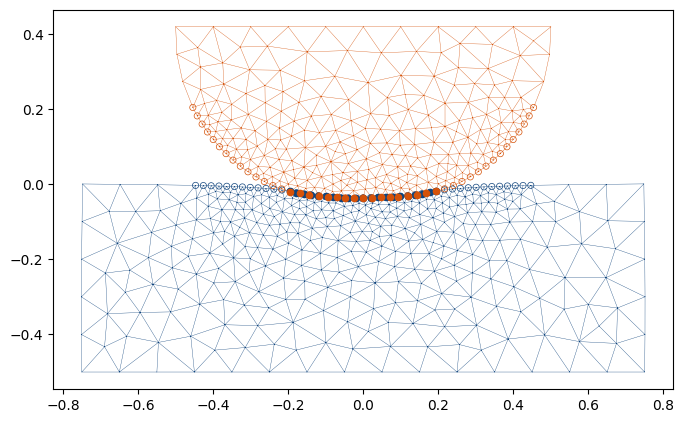


successfully converged in 3 iterations


In [169]:
# Plot initial configuration
fig, ax = plt.subplots(figsize=(8, 5))
plot_mesh(ax,
    internodes_model.nodal_positions,
    mesh.getConnectivity(aka._triangle_3),
    mesh.getElementGroup('primary').getNodeGroup().getNodes().ravel(),
    mesh.getElementGroup('secondary').getNodeGroup().getNodes().ravel(),
    internodes_model.nodes_interface_primary,
    internodes_model.nodes_interface_secondary)
ax.axis('scaled')
plt.show()

max_iter = 10
for i in range(max_iter):
    print("----> Starting iteration", i+1, "<----")

    # Find the interface nodes
    internodes_model.define_interface()

    # Assemble model
    internodes_model.assemble_full_model()

    # Solve model
    displacements, lambdas = internodes_model.solve_direct()

    # Update the interface nodes and check if it converged
    converged, nodes_added_primary, nodes_added_secondary, nodes_dumped_primary, nodes_dumped_secondary = internodes_model.update_interface(displacements, lambdas, return_changes=True)

    # Plot the obtained solution
    fig, ax = plt.subplots(figsize=(8, 5))
    plot_mesh(ax,
        internodes_model.nodal_positions + displacements,
        mesh.getConnectivity(aka._triangle_3),
        mesh.getElementGroup('primary').getNodeGroup().getNodes().ravel(),
        mesh.getElementGroup('secondary').getNodeGroup().getNodes().ravel(),
        internodes_model.nodes_candidate_primary,
        internodes_model.nodes_candidate_secondary,
        internodes_model.nodes_interface_primary,
        internodes_model.nodes_interface_secondary,
        nodes_added_primary,
        nodes_added_secondary,
        nodes_dumped_primary,
        nodes_dumped_secondary)
    ax.axis('scaled')
    plt.show()

    if converged:
        print('\nsuccessfully converged in', i+1, 'iterations')
        break

In [167]:
nodal_positions_new = internodes_model.nodal_positions + displacements
write_solution("mesh/contact2d_circle.msh", nodal_positions_new)

In [6]:
model.getDisplacement()[:] = displacements
model.getMesh().getNodes()[:] = nodal_positions + displacements

In [8]:
model.setBaseName("2d-example")
model.addDumpField("displacement")
model.dump()